In [15]:
from networks import Mine, Klne, FFNet, moving_average
import torch as pt
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [16]:
std_mvn = pt.distributions.MultivariateNormal(pt.zeros(3), pt.eye(3))

target_cov = pt.diag(pt.rand(3))
target_mean = pt.rand(3)
target = pt.distributions.MultivariateNormal(target_mean, target_cov)

In [17]:
def compute_kl(transform):
    A = transform.weight.detach().numpy()
    b = transform.bias.detach().numpy()

    p_mean = b
    p_cov = A @ A.T

    q_cov = target_cov.numpy()
    q_mean = target_mean.numpy()

    mean_diff = p_mean - q_mean

    kl = 0.5 * (np.trace(np.linalg.inv(q_cov) @ p_cov - np.eye(3)) + 
                mean_diff.T @ np.linalg.inv(q_cov) @ mean_diff 
                + np.log(np.linalg.det(q_cov) / np.linalg.det(p_cov)))
    
    return kl

[0]		T:  0.132		KL: 0.136
[100]		T:  0.334		KL: 0.331
[200]		T:  0.437		KL: 0.485
[300]		T:  0.618		KL: 0.603
[400]		T:  0.713		KL: 0.716
[500]		T:  0.792		KL: 0.744
[600]		T:  0.822		KL: 0.752
[700]		T:  0.8		KL: 0.813
[800]		T:  0.815		KL: 0.792
[900]		T:  0.878		KL: 0.880
[1000]		T:  0.858		KL: 0.805
[1100]		T:  0.706		KL: 0.879
[1200]		T:  0.734		KL: 0.815
[1300]		T:  0.845		KL: 0.691
[1400]		T:  0.723		KL: 0.681
[1500]		T:  0.667		KL: 0.741
[1600]		T:  0.715		KL: 0.602
[1700]		T:  0.678		KL: 0.624
[1800]		T:  0.576		KL: 0.654
[1900]		T:  0.675		KL: 0.555
[2000]		T:  0.559		KL: 0.590
[2100]		T:  0.511		KL: 0.475
[2200]		T:  0.496		KL: 0.400
[2300]		T:  0.471		KL: 0.433
[2400]		T:  0.445		KL: 0.538
[2500]		T:  0.501		KL: 0.366
[2600]		T:  0.439		KL: 0.422
[2700]		T:  0.464		KL: 0.428
[2800]		T:  0.329		KL: 0.368
[2900]		T:  0.383		KL: 0.401
[3000]		T:  0.36		KL: 0.388
[3100]		T:  0.357		KL: 0.382
[3200]		T:  0.376		KL: 0.279
[3300]		T:  0.336		KL: 0.335
[3400]		T:  0.31		KL: 0.360
[

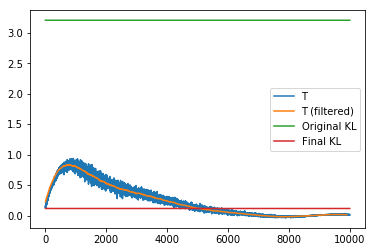

In [18]:
np.random.seed(0)
pt.manual_seed(0)

training_iters = 10000
samples = 1000

T = FFNet([3, 100, 1])
transform = pt.nn.Linear(3, 3)

values = np.zeros(training_iters)
kls = np.zeros(training_iters)

T_opt = optim.Adam(T.parameters(), lr=0.0001)
kl_opt = optim.Adam(transform.parameters(), lr=0.0001)

kl_start = compute_kl(transform)

for i in range(training_iters):
    p = transform(std_mvn.sample((samples,)))
    q = target.sample((samples,))
    
    # Biased loss
    T_loss = -(T(p).mean() - pt.log(pt.exp(T(q)).mean()))
    
    values[i] = (T(p).mean() - pt.log(pt.exp(T(q)).mean())).detach().item()    
    
    T_opt.zero_grad()
    T_loss.backward()
    T_opt.step()    
        
    p = transform(std_mvn.sample((samples,)))
    q = target.sample((samples,))
    kl_loss = (T(p).mean() - pt.log(pt.exp(T(q)).mean()))

    kl_opt.zero_grad()
    kl_loss.backward()
    kl_opt.step()

    kls[i] = kl_loss.detach().item()

    if i % 100 == 0:
        print(f'[{i}]\t\tT:  {values[i]:.3}\t\tKL: {kls[i]:.3f}')
        
kl_end = compute_kl(transform)

plt.plot(values, label='T')
plt.plot(moving_average(values, 100), label='T (filtered)')
plt.plot(kl_start * np.ones(training_iters), label='Original KL')
plt.plot(kl_end * np.ones(training_iters), label='Final KL')
plt.legend()

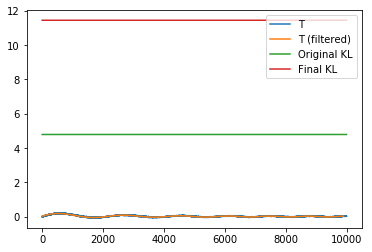

In [13]:
plt.plot(values, label='T')
plt.plot(moving_average(values, 100), label='T (filtered)')
plt.plot(kl_start * np.ones(training_iters), label='Original KL')
plt.plot(kl_end * np.ones(training_iters), label='Final KL')
plt.legend()

In [98]:
T._linears[0].weight.shape

torch.Size([100, 3])

In [99]:
transform.weight

Parameter containing:
tensor([[ 0.0213,  0.0268,  0.0193],
        [ 1.6283, -0.1646, -0.3363],
        [ 3.2744, -0.3984, -0.8200]], requires_grad=True)

In [40]:
b = pt.tensor([[3.0]], requires_grad=True)

In [41]:
c = f(b)

In [42]:
c.backward()

In [21]:
a = pt.zeros((2, 3), requires_grad=False)

In [23]:
b = pt.rand((3,))

In [27]:
b.requires_grad_(True)

tensor([0.3274, 0.9157, 0.5253], requires_grad=True)

In [29]:
a[0, :] = b

In [30]:
a

tensor([[0.3274, 0.9157, 0.5253],
        [0.0000, 0.0000, 0.0000]], grad_fn=<CopySlices>)

In [31]:
a.sum().backward()

In [32]:
b.grad

tensor([1., 1., 1.])